<a href="https://colab.research.google.com/github/ak7991/regression_classical/blob/main/poly_regression_svr_dectree_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DESCRIBE THE DATA IN TEXT FORMAT

NAME OF DATASET: The Boston Housing Dataset

COLLECTION DETAILS: The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of [ Boston MA](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). 

FEATURES:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per \$10,000
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in \$1000's



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

['housing.csv']


In [ ]:
# Loading the data
# necessary if the data does not have the columns as the first row
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

TARGET_COLUMN = 'MEDV'
FEATURE_COLUMNS = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Put "header" argument = row index if headers are present in the dataset
data = pd.read_csv('../input/housing.csv', header=None, delimiter=r"\s+", names=column_names)

# EDA

> Check how the first few rows look like
> Check the dimensions of the data to see number of samples and features

In [ ]:
print(data.head(5))
# Dimension of the dataset
print(data.shape)

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
(506, 14)


In [ ]:
# Summarize the data to see the distribution of data
print(data.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677082   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

From get-go,  two data coulmns show interesting summeries. They are : ZN (proportion of residential land zoned for lots over 25,000 sq.ft.)  with 0 for 25th, 50th percentiles. Second, CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise) with 0 for 25th, 50th and 75th percentiles. These summeries are understandable as both variables are conditional + categorical variables. First assumption would be that these coulms may not be useful in regression task such as predicting MEDV (Median value of owner-occupied homes).

Another interesing fact on the dataset is the max value of MEDV. From the original data description, it says: Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000). Based on that, values above 50.00 may not help to predict MEDV. Let's plot the dataset and see interesting trends/stats.

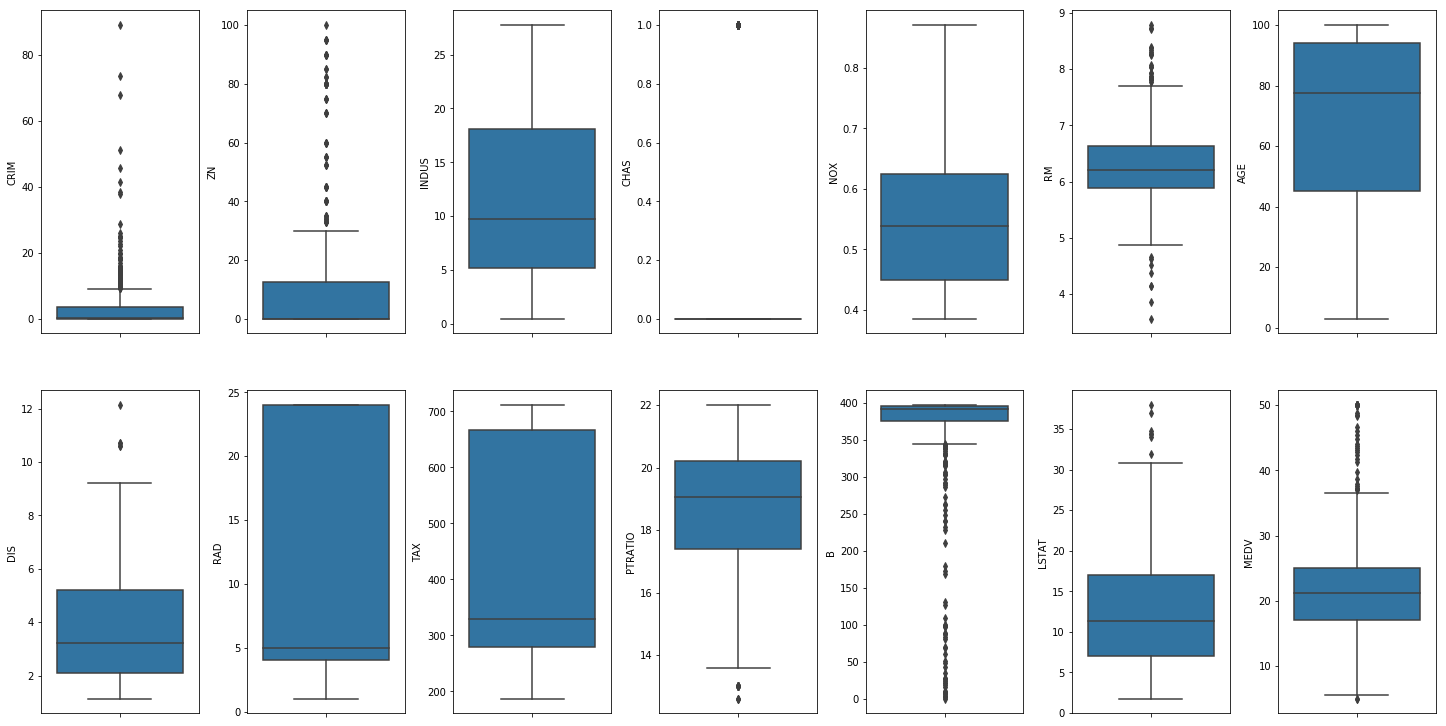

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

50.0

In [ ]:
# Getting a sense of outlier percentage for each column
for k, v in data.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    outliers = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    outlier_ratio = outliers.shape[0] / data.shape[0]
    print(f"Column {k} outliers = {100 * outlier_ratio}")

Column CRIM outliers = 13.043478260869565
Column ZN outliers = 13.438735177865613
Column INDUS outliers = 0.0
Column CHAS outliers = 100.0
Column NOX outliers = 0.0
Column RM outliers = 5.928853754940711
Column AGE outliers = 0.0
Column DIS outliers = 0.9881422924901186
Column RAD outliers = 0.0
Column TAX outliers = 0.0
Column PTRATIO outliers = 2.9644268774703555
Column B outliers = 15.217391304347828
Column LSTAT outliers = 1.383399209486166
Column MEDV outliers = 7.905138339920949


In [ ]:
# Removing target column outliers before plotting more distributions
outlier_percentile = 0.98
outlier_threshold = data[TARGET_COLUMN].quantile(0.98)

data_filtered = data[~(data[TARGET_COLUMN] >= outlier_threshold)]
print("Shape after trimming outliers from target column: ", data.shape)

Shape after trimming outliers from target column:  (506, 14)


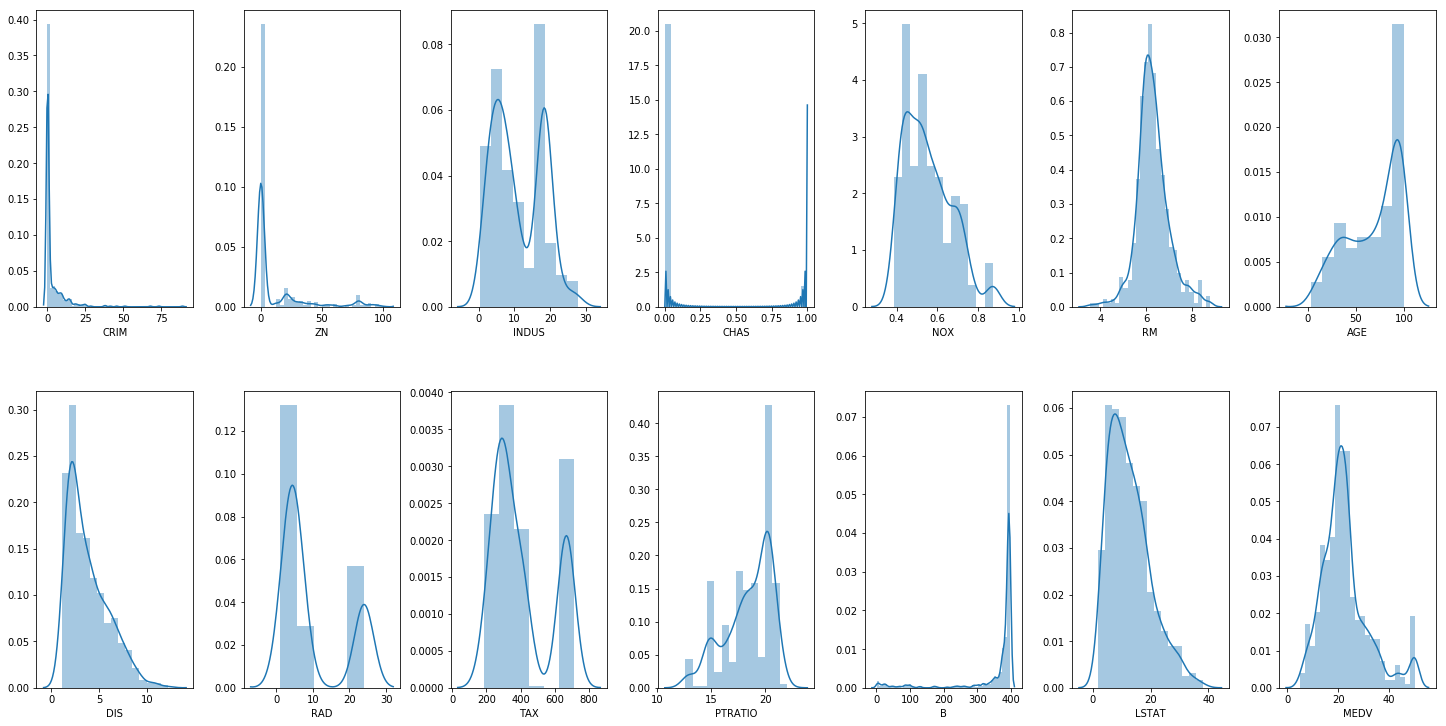

In [ ]:
# Plotting each feature against target column

# put in number of ncols and nrows according to number feature columns

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

The histogram also shows that columns CRIM, ZN, B has highly skewed distributions. Also MEDV looks to have a normal distribution (the predictions) and other colums seem to have normal or bimodel ditribution of data except CHAS (which is a discrete variable).

Now let's plot the pairwise  correlation on data.

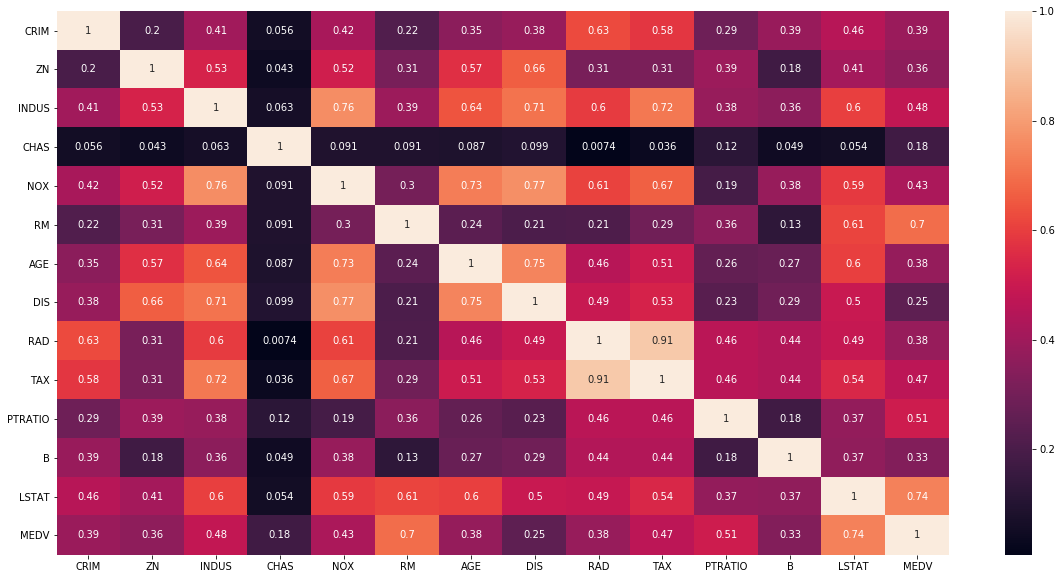

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV. 

In [ ]:
corr_thresh = 0.4
high_corr_cols = []

target_correlations = data.corr().abs()[[TARGET_COLUMN]]

for col in target_correlations.iterrows():
    if col[1].loc[TARGET_COLUMN] >= corr_thresh:
        print(f"Column {col[0]} has a high correlation with {TARGET_COLUMN} [{col[1].loc[TARGET_COLUMN]}]")
        high_corr_cols.append(col[0])

high_corr_cols.remove(TARGET_COLUMN)  # ofc correlation with itself is 1
print(f"\n{high_corr_cols} have high correlations with the target column")

Column INDUS has a high correlation with MEDV [0.483725160028373]
Column NOX has a high correlation with MEDV [0.4273207723732817]
Column RM has a high correlation with MEDV [0.6953599470715389]
Column TAX has a high correlation with MEDV [0.46853593356776646]
Column PTRATIO has a high correlation with MEDV [0.507786685537561]
Column LSTAT has a high correlation with MEDV [0.7376627261740143]
Column MEDV has a high correlation with MEDV [1.0]

['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'] have high correlations with the target column


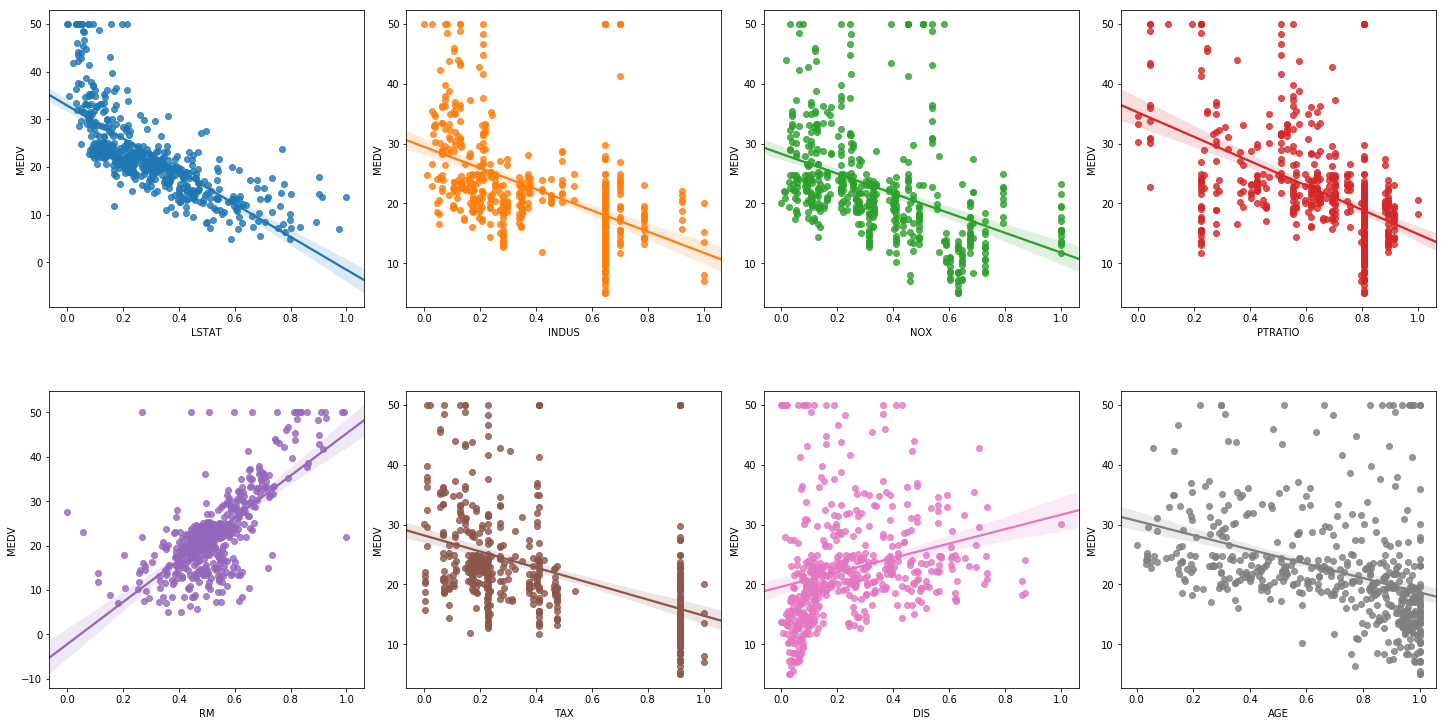

In [ ]:
# Somewhat arbitrarily choosing columns [generally excluding low correlation/skewed columns]
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data.loc[:,column_sels]
# min-max scaling
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
y = data[TARGET_COLUMN]
# Carefully choose ncols and nrows in subplots according to number of column_sels
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


# FEATURE ENGINEERING

Check if converting values to log scale might help reduce skewness. This is specially beneficial if the target column is not skewed but the feature column is.


In [ ]:
x_transformed = x.copy()
y =  np.log1p(y)
for col in x_transformed.columns:
    original_skew = np.abs(x_transformed[col].skew())
    if original_skew > 0.3:
        log_values = np.log1p(x_transformed[col])
        log_skew = np.abs(log_values.skew())
        if log_skew < original_skew:
            x_transformed[col] = log_values
            print(f"Applied transformation f(x) = log(x) on column {col}")
            print(f"Skew reduced from {original_skew} to {log_skew}\n")

Applied transformation f(x) = log(x) on column LSTAT
Skew reduced from 0.9064600935915385 to 0.578044583567536

Applied transformation f(x) = log(x) on column NOX
Skew reduced from 0.7293079225348797 to 0.40969717913352066

Applied transformation f(x) = log(x) on column RM
Skew reduced from 0.40361213328874396 to 0.12778893363015192

Applied transformation f(x) = log(x) on column TAX
Skew reduced from 0.6699559417950154 to 0.5115869598105677

Applied transformation f(x) = log(x) on column DIS
Skew reduced from 1.0117805793009016 to 0.7343784202036057



Let's try Linear, Ridge Regression on dataset first.

In [ ]:
print("a digit %d" % (2))

a digit 2


In [ ]:
# Some Parameters for training

# Number of folds for cross validation
kf = KFold(n_splits=10)
# Scoring tactic
scoring = 'neg_mean_squared_error'


# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
x_scaled = x
scores_map = {}

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np


# Simple linear regression
l_regression = linear_model.LinearRegression()
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring=scoring)
scores_map['LinearRegression'] = scores
print("MSE [Simple Linear Regression]: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))



l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring=scoring)
scores_map['Ridge'] = scores
print("MSE [Ridge Regression]: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Trying ridge regression with a range of polynomial degrees
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
for degree in range(1, 10):
    model = make_pipeline(PolynomialFeatures(degree=degree), linear_model.Ridge())
    scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    print("MSE [%d degree regression]: %0.2f (+/- %0.2f)" % (degree, scores.mean(), scores.std()))
    scores_map[f"Polynomial {degree}"] = scores


MSE [Simple Linear Regression]: -0.05 (+/- 0.06)
MSE [Ridge Regression]: -0.05 (+/- 0.06)
MSE [1 degree regression]: -0.05 (+/- 0.06)
MSE [2 degree regression]: -0.04 (+/- 0.05)
MSE [3 degree regression]: -0.04 (+/- 0.04)
MSE [4 degree regression]: -0.04 (+/- 0.04)
MSE [5 degree regression]: -0.04 (+/- 0.04)
MSE [6 degree regression]: -0.04 (+/- 0.04)
MSE [7 degree regression]: -0.04 (+/- 0.04)
MSE [8 degree regression]: -0.05 (+/- 0.04)
MSE [9 degree regression]: -0.05 (+/- 0.04)


Above cell's output can be analyzed to see which degree of polynomial fits best. Generally the accuracy should increase with the degree of polynomial and then start to decrease after a plateau has been reached.

The Liner Regression with and without L2 regularization does not make significant difference is MSE score. However polynomial regression with degree=3 has a better MSE. Let's try some non prametric regression techniques: SVR with kernal rbf, DecisionTreeRegressor, KNeighborsRegressor etc.

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(kernel='rbf')
grid_sv = GridSearchCV(svr_rbf, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier : ", grid_sv.best_estimator_)
svr_best = grid_sv.best_estimator_

scores = cross_val_score(svr_best, x_scaled, y, cv=kf, scoring=scoring)
scores_map['SVR'] = scores
print("MSE [Support Vector Regression]: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Best classifier : SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSE [Support Vector Regression]: -0.04 (+/- 0.03)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

desc_tr = DecisionTreeRegressor()
grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : np.linspace(1, 10, 10)}, scoring=scoring)
grid_sv.fit(x_scaled, y)
print("Best classifier : ", grid_sv.best_estimator_)
desc_tr_best = grid_sv.best_estimator_
scores = cross_val_score(desc_tr_best, x_scaled, y, cv=kf, scoring=scoring)
scores_map['DecisionTreeRegressor'] = scores
print("MSE [Decision Tree]: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Best classifier :  DecisionTreeRegressor(criterion='mse', max_depth=3.0, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
MSE [Decision Tree]: -0.06 (+/- 0.04)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring=scoring)
scores_map['KNeighborsRegressor'] = scores
grid_sv = GridSearchCV(knn, cv=kf, param_grid={"n_neighbors" : np.linspace(2, 9, 8, dtype=int)}, scoring=scoring)
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Best classifier : KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
KNN Accuracy: -0.05 (+/- 0.04)


Compared to three models which are shosen through grid search, SVR performes better. Let's try an ensemble method finally.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# gbr = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
gbr = GradientBoostingRegressor(alpha=0.9, min_samples_split=2, n_estimators=100, random_state=30)
param_grid = {'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}
grid_sv = GridSearchCV(gbr, cv=kf, param_grid=param_grid, scoring=scoring)
grid_sv.fit(x_scaled, y)
print("Best classifier : ", grid_sv.best_estimator_)
scores = cross_val_score(grid_sv.best_estimator_, x_scaled, y, cv=kf, scoring=scoring)
scores_map['GradientBoostingRegressor'] = scores
print("MSE [XGBoost]: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))


Best classifier :  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=30,
             subsample=1.0, verbose=0, warm_start=False)
MSE [XGBoost]: -0.03 (+/- 0.03)


Let's plot k-fold results to see which model has better distribution of results. Let's have a look at the MSE distribution of these models with k-fold=10

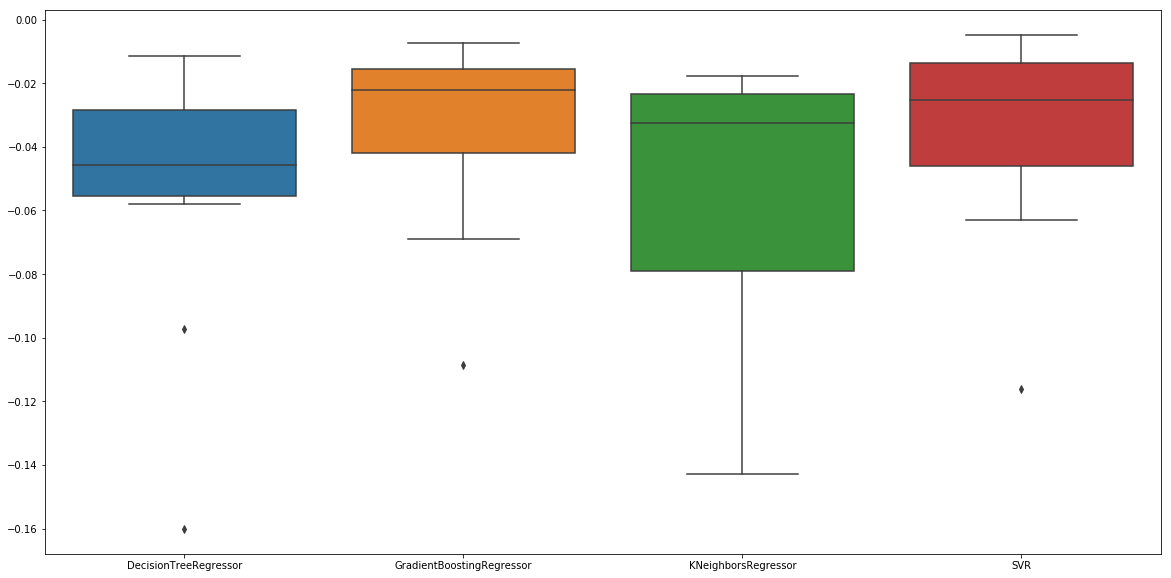

In [ ]:
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)

The models SVR and GradientBoostingRegressor show better performance with -11.62 (+/- 5.91) and -12.39 (+/- 5.86).

This is my first kernel and thanks to https://www.kaggle.com/vikrishnan for the dataset and the well writtten kernel that provdies great pointers into this dataset.